In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

# import data
from statsmodels.gam.tests.test_penalized import df_autos
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_autos.head()

,city_mpg,fuel,drive,weight,hp
0,21,gas,rwd,2548,111.0
1,21,gas,rwd,2548,111.0
2,19,gas,rwd,2823,154.0
3,24,gas,fwd,2337,102.0
4,18,gas,4wd,2824,115.0


# Gaussian response with GAM 

This file is borrowed from josef-pkt on his blog

We need to provide an instance of a spline basis class to the model. Currently there are two verified spline basis, B-Splines and CyclicCubicSplines.

The model class also takes the penalization weight alpha as argument. This is currently a model attribute and changing it on an existing instance might cause the results instance to produce inconsistent results if it uses the changed attribute.

We specify here alpha values from the unit tests which were obtained by the R mgcv package. At the end we will illustrate the methods to select an optimal alpha.

In [4]:
# create spline basis for weight and hp
x_spline = df_autos[['weight', 'hp']]
bs = BSplines(x_spline, df=[12, 10], degree=[3, 3])

# penalization weight
alpha = np.array([21833888.8, 6460.38479])

The model class for generalized additive models is GLMGam. As other models, it can be used either with numpy arrays, pandas DataFrames or using the formula interface. The formula interface currently only supports the linear part. Specifying penalized splines inside the formulas is not yet supported. (patsy supports unpenalized splines in the formulas.)

In [7]:
gam_bs = GLMGam.from_formula('city_mpg ~ fuel + drive', data=df_autos,
                             smoother=bs, alpha=alpha)
res_bs = gam_bs.fit()
print(res_bs.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               city_mpg   No. Observations:                  203
Model:                         GLMGam   Df Residuals:                   189.13
Model Family:                Gaussian   Df Model:                        12.87
Link Function:               identity   Scale:                          4.8825
Method:                         PIRLS   Log-Likelihood:                -441.81
Date:                Tue, 27 Apr 2021   Deviance:                       923.45
Time:                        16:51:49   Pearson chi2:                     923.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       51.9923      1.997     26.034   

The results classes have a plot_partial method that plots the partial linear prediction of a smooth component. The partial residual or component plus residual can be added as scatter point with cpr=True.

The plots show that both smooth explanatory variables, weight and hp have a downward sloping effect, i.e. cars with larger weight and horsepower have higher fuel consumption and a smaller miles per gallon. However, the effect levels of at higher values, and a linear function would not have been appropriate.

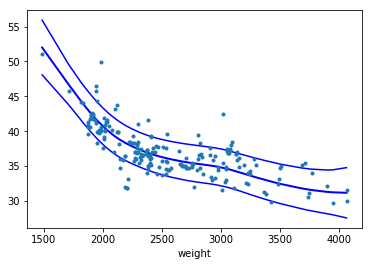

In [10]:
# plot smooth components
res_bs.plot_partial(0, cpr=True)
plt.show()

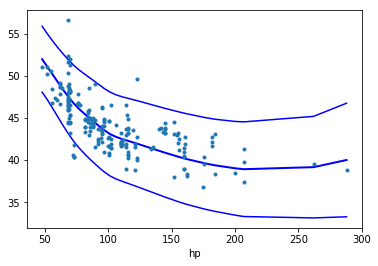

In [11]:
res_bs.plot_partial(1, cpr=True)
plt.show()

In [16]:
pred = res_bs.predict()
print(pred)

[22.33368889 22.33368889 18.86664718 24.60057454 20.21243345 22.81028635
 21.24425701 20.85058172 18.79431753 17.36228557 24.0338629  24.0338629
 20.93527635 20.71460668 19.7072696  16.61543041 16.18243577 15.82445763
 44.46693341 33.5515182  32.97314737 33.76492366 33.76492366 26.65566417
 32.28991617 31.95176831 31.95176831 25.96735769 24.31879346 19.45473243
 38.08013399 33.75052366 35.46538949 31.77432671 31.52846179 30.72647896
 30.52583543 26.91437379 26.39007835 26.24946425 25.65418377 23.72396139
 25.14035764 26.49248033 33.5515182  32.97314737 22.94107284 14.47260999
 14.47260999 12.90217325 33.53015196 33.36418857 33.28175004 32.63537633
 32.556232   24.14746042 24.14746042 24.10925204 21.16206579 25.72743423
 25.52900176 25.72743423 25.52900176 34.54399928 25.41416493 21.16562039
 31.28844106 22.98210287 22.02635141 23.06494007 21.946843   16.03315239
 16.19353046 14.67991828 15.17811151 17.78010508 33.06911122 32.65124946
 31.72552397 26.46383669 23.3250889  25.85161806 19.

# Poisson with GAM

Miles per gallon can take on only positive values, so we can use Poisson with a log-link to impose that the prediction is non-negative. Except for adding the family, everything works the same as in the Gaussian case. One difference is that the non-linear link implies that predict_partial and plot_partial are not in terms of the response variable. Those are still for the linear prediction, i.e. the values before applying the inverse link, exp in this case.

In [12]:
alpha = np.array([8283989284.5829611, 14628207.58927821])
gam_bs = GLMGam.from_formula('city_mpg ~ fuel + drive', data=df_autos,
                             smoother=bs, alpha=alpha,
                             family=sm.families.Poisson())
res_bs = gam_bs.fit()
print(res_bs.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               city_mpg   No. Observations:                  203
Model:                         GLMGam   Df Residuals:                   194.75
Model Family:                 Poisson   Df Model:                         7.25
Link Function:                    log   Scale:                          1.0000
Method:                         PIRLS   Log-Likelihood:                -530.38
Date:                Tue, 27 Apr 2021   Deviance:                       37.569
Time:                        17:00:49   Pearson chi2:                     37.4
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.9960      0.130     30.844   

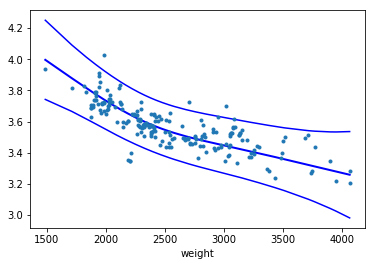

In [17]:
res_bs.plot_partial(0, cpr=True)
plt.show()

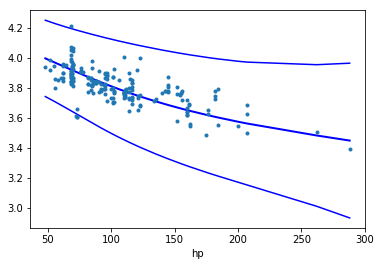

In [13]:
res_bs.plot_partial(1, cpr=True)
plt.show()

In [18]:
pred = res_bs.predict()
print(pred)

[22.33368889 22.33368889 18.86664718 24.60057454 20.21243345 22.81028635
 21.24425701 20.85058172 18.79431753 17.36228557 24.0338629  24.0338629
 20.93527635 20.71460668 19.7072696  16.61543041 16.18243577 15.82445763
 44.46693341 33.5515182  32.97314737 33.76492366 33.76492366 26.65566417
 32.28991617 31.95176831 31.95176831 25.96735769 24.31879346 19.45473243
 38.08013399 33.75052366 35.46538949 31.77432671 31.52846179 30.72647896
 30.52583543 26.91437379 26.39007835 26.24946425 25.65418377 23.72396139
 25.14035764 26.49248033 33.5515182  32.97314737 22.94107284 14.47260999
 14.47260999 12.90217325 33.53015196 33.36418857 33.28175004 32.63537633
 32.556232   24.14746042 24.14746042 24.10925204 21.16206579 25.72743423
 25.52900176 25.72743423 25.52900176 34.54399928 25.41416493 21.16562039
 31.28844106 22.98210287 22.02635141 23.06494007 21.946843   16.03315239
 16.19353046 14.67991828 15.17811151 17.78010508 33.06911122 32.65124946
 31.72552397 26.46383669 23.3250889  25.85161806 19.

# A more powerful package: pyGAM

pyGAM is a python package that is designed specifically for GAM. It is more powerful and includes more variations of models and smoothers. For example:

1. LinearGAM identity link and normal distribution
2. LogisticGAM logit link and binomial distribution
3. PoissonGAM log link and Poisson distribution
4. GammaGAM log link and gamma distribution
5. InvGauss log link and inv_gauss distribution

https://pygam.readthedocs.io/en/latest/

# Linear GAM: identity link function

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 432x288 with 0 Axes>

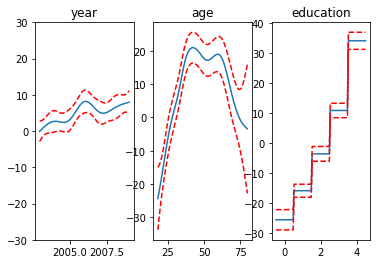

In [29]:
from pygam import LinearGAM, s, f
from pygam.datasets import wage

X, y = wage(return_X_y=True)

## model
gam = LinearGAM(s(0) + s(1) + f(2))
gam.gridsearch(X, y)


## plotting
plt.figure();
fig, axs = plt.subplots(1,3);

titles = ['year', 'age', 'education']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i]);
plt.show()

In [25]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     19.2602
Link Function:                     IdentityLink Log Likelihood:                                -24116.7451
Number of Samples:                         3000 AIC:                                            48274.0107
                                                AICc:                                           48274.2999
                                                GCV:                                             1250.3656
                                                Scale:                                           1235.9245
                                                Pseudo R-Squared:                                   0.2945
Feature Function                  Lam

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


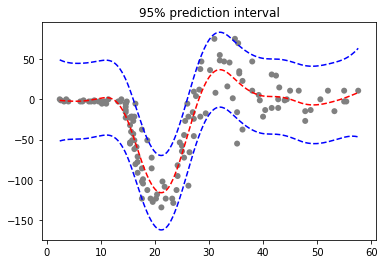

In [26]:
from pygam import LinearGAM
from pygam.datasets import mcycle

X, y = mcycle(return_X_y=True)

gam = LinearGAM(n_splines=25).gridsearch(X, y)
XX = gam.generate_X_grid(term=0, n=500)

plt.plot(XX, gam.predict(XX), 'r--')
plt.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--')

plt.scatter(X, y, facecolor='gray', edgecolors='none')
plt.title('95% prediction interval')
plt.show()

# LogisticGAM

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


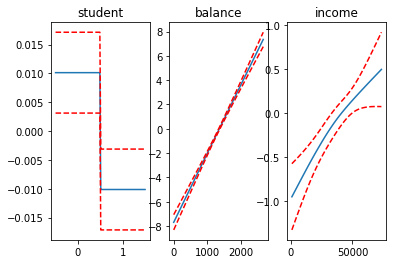

In [31]:
from pygam import LogisticGAM, s, f
from pygam.datasets import default

X, y = default(return_X_y=True)

gam = LogisticGAM(f(0) + s(1) + s(2)).gridsearch(X, y)

fig, axs = plt.subplots(1, 3)
titles = ['student', 'balance', 'income']

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);
plt.show()

In [32]:
gam.accuracy(X, y)

0.9739

In [33]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.8047
Link Function:                        LogitLink Log Likelihood:                                   -788.877
Number of Samples:                        10000 AIC:                                             1585.3634
                                                AICc:                                             1585.369
                                                UBRE:                                               2.1588
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.4598
Feature Function                  Lam

# PoissonGAM

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


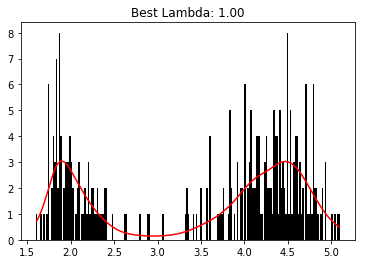

In [34]:
from pygam import PoissonGAM
from pygam.datasets import faithful

X, y = faithful(return_X_y=True)

gam = PoissonGAM().gridsearch(X, y)

plt.hist(faithful(return_X_y=False)['eruptions'], bins=200, color='k');
plt.plot(X, gam.predict(X), color='r')
plt.title('Best Lambda: {0:.2f}'.format(gam.lam[0][0]));
plt.show()